# Lorenz '63 DIRESA tutorial

<a target="_blank" href="https://colab.research.google.com/github/gdepaepe/diresa/blob/main/diresa.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Install packages
The `diresa` package depends on the `tensorflow` and `tensorflow_probability` packages. This tutorial also uses `numpy` and `matplotlib`. 

In [1]:
# Install needed packages
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install tensorflow_probability
!pip install diresa

### 2. Load the dataset
In this tutorial, we are going to compress the 3D lorenz '63 butterfly into a 2D latent space. The `lorenz.csv` contains a list of butterfly points, with three colums for the X, Y and Z coordinate. The DIRESA model has 2 inputs: the original dataset and a shuffled version of this dataset for the twin encoder.

In [2]:
!wget https://gitlab.com/etrovub/ai4wcm/public/diresa/-/raw/master/docs/lorenz.csv

In [3]:
import numpy as np
data_file = "lorenz.csv"
train = np.loadtxt(data_file, delimiter=",")
print("Shape", data_file, ":", train.shape)
id_train = np.argsort((np.random.random(train.shape[0])))
train_twin = train[id_train]

Shape lorenz.csv : (40000, 3)


### 3. Build the DIRESA model
We can build a DIRESA model with convolutional and/or dense layers with the `build_diresa` function. We can also build a DIRESA model based on a custom encoder and decoder with the `diresa_model` function (see below). We build here a model with an input shape of `(3,)` for the 3D butterfly points. Our encoder model has 3 dense layers with 40, 20 and 2 units (the latter is the dimension of the latent space). The decoder is a reflection of the encoder. The DIRESA model has 3 loss functions, the reconstruction loss (usually the MSE is used here), the covariance loss and a distance loss (here the MSE distance loss is used). Also the weights for the diffenent loss functions are specified.

In [4]:
from diresa.models import build_diresa
from diresa.loss import mse_dist_loss, LatentCovLoss

diresa = build_diresa(input_shape=(3,), dense_units=(40, 20, 2))

diresa.compile(loss=['MSE', LatentCovLoss(1.), mse_dist_loss], loss_weights=[1., 3., 1.])
diresa.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 Shuffled_Input (InputLayer  [(None, 3)]                  0         []                            
 )                                                                                                
                                                                                                  
 Encoder (Functional)        (None, 2)                    1022      ['Input[0][0]',               
                                                                     'Shuffled_Input[0][0]']      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

### 4. Train the DIRESA model
We train the DIRESA model in a standard way. The output of the decoder should fit the input of the encoder. The batch size should be large enough for the calculation of the covariance loss, which calculates the covariance matrix of the latent space components over the batch.

In [5]:
diresa.fit((train, train_twin), train, epochs=20, batch_size=512, shuffle=True, verbose=2)

Epoch 1/20
79/79 - 2s - loss: 0.0996 - Decoder_loss: 0.0681 - Latent_loss: 0.0010 - dist_layer_loss: 0.0284 - 2s/epoch - 25ms/step
...Epoch 20/20
79/79 - 0s - loss: 8.9278e-04 - Decoder_loss: 6.2064e-04 - Latent_loss: 1.4375e-05 - dist_layer_loss: 2.2901e-04 - 205ms/epoch - 3ms/step


### 5. Encoder and decoder submodel
We cut out the encoder and decoder submodels with the `cut_sub_model` function. So we can make predictions for latent and decoded space.

In [6]:
from diresa.toolbox import cut_sub_model
compress_model = cut_sub_model(diresa, 'Encoder')
decode_model = cut_sub_model(diresa, 'Decoder')
latent = compress_model.predict(train)
predict = decode_model.predict(latent)

1250/1250 [==============================] - 2s 1ms/step


### 6. Show latent space
We plot the 2D latent space.

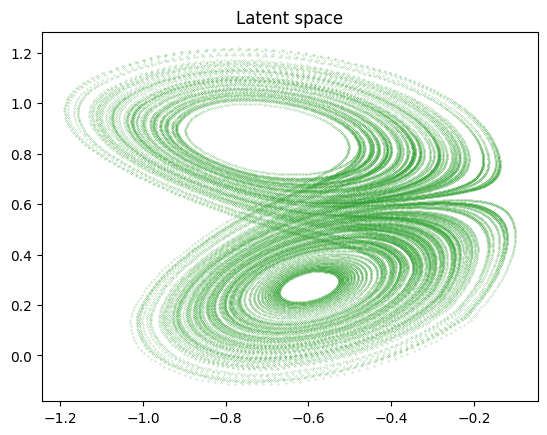

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Latent space")
plt.scatter(latent[:, 0], latent[:, 1], marker='.', s=0.1, color='C2')
plt.show()

### 6. Original versus decoded datset
We compair the origonal dataset with the decoded one.

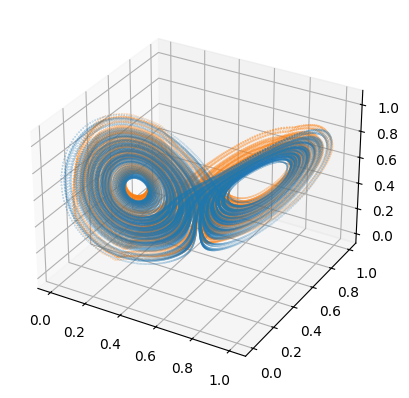

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(train[:, 0], train[:, 1], train[:, 2], marker='.', s=0.1)
ax.scatter(predict[:, 0], predict[:, 1], predict[:, 2], marker='.', s=0.1, color='C1')
plt.show()

### 8. Build DIRESA with custom encoder and decoder
We can also build DIRESA models with custom encoder and decoder models. We define those two here.

In [9]:
from keras import layers, Input
from keras.models import Model
def encoder_model(input_shape=(3,), output_shape=2, units=40):
    x = Input(shape=input_shape)
    y = layers.Dense(units=units, activation="relu")(x)
    y = layers.Dense(units=units // 2, activation="relu")(y)
    y = layers.Dense(output_shape, activation="linear")(y)
    model = Model(x, y, name="Encoder")
    return model
def decoder_model(input_shape=2, output_shape=3, units=40):
    x = Input(shape=input_shape)
    y = layers.Dense(units=units // 2, activation="relu")(x)
    y = layers.Dense(units=units, activation="relu")(y)
    y = layers.Dense(output_shape, activation="linear")(y)
    model = Model(x, y, name="Decoder")
    return model

Based on the custom encoder and decoder model, we now build the DIRESA model with the `diresa_model` function. 

In [10]:
from diresa.models import diresa_model
from diresa.loss import mse_dist_loss, LatentCovLoss

diresa = diresa_model(x=Input(shape=3), x_twin=Input(shape=3), encoder=encoder_model(), decoder=decoder_model())

diresa.compile(loss=['MSE', LatentCovLoss(1.), mse_dist_loss], loss_weights=[1., 3., 1.])
diresa.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 Encoder (Functional)        (None, 2)                    1022      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_3 (InputLayer)       [(None, 3)]                  0         []                      

### 9. Reference

In [11]:
from diresa import *
help(models)
#help(loss)

Help on module diresa.models in diresa:

NAME
    diresa.models

DESCRIPTION
    Creates DIRESA and (V)AE models out of an encoder and decoder model
    Creates DIRESA and AE models from hyperparameters
    :Author:  Geert De Paepe
    :Email:   geert.de.paepe@vub.be
    :License: Apache 2.0
    
    1. Creating (V)AE and Diresa models out of an encoder and decoder model:
     - autoencoder_model(x, encoder, decoder, mask_layer=False)
     - vae_model(x, encoder, decoder)
     - cov_reg_ae_model(x, encoder, decoder)
     - siamese_twin_model(x, x_twin, encoder, decoder)
     - diresa_model(x, x_twin, encoder, decoder)
    
    2. Creating AE and Diresa models from hyperparameters
       - build_ae(input_shape, stack, stack_filters, latent_filters, kernel_size=(3, 3),
                  conv_transpose=False, up_first=False, residual=False, batchnorm=False,
                  dense_units=(), mask_layer=False,
                  activation='relu', encoder_activation='linear', decoder_activat